### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831582
Bad     0.168418
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [7]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [8]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(75780, 78)

In [9]:
df_balanced_2.Nationality_Recode.value_counts()

North America          11538
Western Europe         11519
UK & Ireland           11513
Middle east            11477
Eastern Europe          8829
Asia & Pacific          7680
Oceania                 7604
Sub-Saharian Africa     2058
South/Latin America     1610
China                   1099
Arab States              853
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [10]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(20000, 78)

In [11]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [12]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [13]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [14]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [71]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 76), (10000,), (10000, 76), (10000,))

## MODELS

### Evaluate Model

In [72]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer

In [73]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [74]:
def evaluate_random(model, params, iterations, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = iterations, scoring = f1, 
                             n_jobs = -1, cv = 5, random_state = 27, verbose = verbose)
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [75]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = GridSearchCV(estimator = model, param_grid = params, scoring = f1, n_jobs = -1, cv = 5, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [76]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}')
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}')

### KNN

In [77]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.5991 | F1 Test : 0.5987
Accuracy Train: 0.7382 | F1 Train: 0.7402


### Gradient Boosted Trees

In [83]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}

pred_gbt = evaluate_random(GradientBoostingClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'subsample': 1, 'n_estimators': 108, 'min_samples_split': 0.9272727272727272, 'min_samples_leaf': 0.11393939393939392, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.001} 0.6813671058566237
Accuracy Test : 0.6388 | F1 Test : 0.6811
Accuracy Train: 0.6469 | F1 Train: 0.6895


In [24]:
# pred_gbt = evaluate_model(GradientBoostingClassifier(n_estimators = 165, 
#                                                      min_samples_split = 0.6272727272727272, 
#                                                      min_samples_leaf = 0.11888888888888888, 
#                                                      max_depth = 2, learning_rate = 0.001),
#                           X_train, X_test, y_train, y_test)

### Random Forest

In [82]:
iterations = 100
params = {'bootstrap': [True, False],
          'max_depth': range(1, 10),
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': range(1, 10),
          'min_samples_split': range(1, 10),
          'n_estimators': range(100, 200)}

pred_rf = evaluate_random(RandomForestClassifier(random_state = 1), params, iterations, 
                          X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 104, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False} 0.668140795949073
Accuracy Test : 0.6484 | F1 Test : 0.6567
Accuracy Train: 0.6829 | F1 Train: 0.6926


In [26]:
# pred_rf = evaluate_model(RandomForestClassifier(n_estimators = 153, min_samples_split = 5,  min_samples_leaf = 7,
#                                                 max_features = 'auto', max_depth = 2, bootstrap = False, random_state=1), 
#                          X_train, X_test, y_train, y_test)

### XGBoosting

In [81]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb = evaluate_random(xgb.XGBClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 15, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 1.0} 0.6727454475939748
Accuracy Test : 0.6403 | F1 Test : 0.6684
Accuracy Train: 0.6453 | F1 Train: 0.6741


In [28]:
# pred_xgb = evaluate_model(xgb.XGBClassifier(n_estimators = 7, min_child_weight = 5, max_depth = 3, learning_rate = 0.005,
#                                             gamma = 0.05, colsample_bytree = 1, random_state = 1), 
#                     X_train, X_test, y_train, y_test)

### Logistic Regresion

In [80]:
params = {"C": [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1],
          "tol": [0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]}

pred_log = evaluate_grid(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                         params, X_train, X_test, y_train, y_test, verbose = 0)

{'C': 0.01, 'tol': 1e-05} 0.6667386209306692
Accuracy Test : 0.6555 | F1 Test : 0.6566
Accuracy Train: 0.6670 | F1 Train: 0.6719


In [30]:
# pred_log = evaluate_model(LogisticRegression(C = 0.1, tol = 0.00001, solver='lbfgs', max_iter=1000, random_state=1), 
#                           X_train, X_test, y_train, y_test)

### Decision Trees

In [78]:
iterations = 200
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                            X_train, X_test, y_train, y_test, verbose = 0)

{'min_samples_leaf': 2, 'max_features': 12, 'max_depth': 3, 'criterion': 'gini'} 0.6856733638524558
Accuracy Test : 0.6328 | F1 Test : 0.6797
Accuracy Train: 0.6402 | F1 Train: 0.6879


In [44]:
pred_tree = evaluate_model(DecisionTreeClassifier(min_samples_leaf = 4, max_features = 19, max_depth = 3, 
                                                  criterion = 'entropy', random_state = 1), 
                     X_train, X_test, y_train, y_test)

Accuracy Test : 0.6424 | F1 Test : 0.6831
Accuracy Train: 0.6491 | F1 Train: 0.6864


### SVM

In [84]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

pred_svm = evaluate_grid(SVC(random_state = 1), params, X_train, X_test, y_train, y_test, verbose = 0)

C:\Users\PC\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'C': 0.001, 'degree': 3, 'kernel': 'poly'} 0.7002858960634858
Accuracy Test : 0.6313 | F1 Test : 0.6831
Accuracy Train: 0.6394 | F1 Train: 0.6915


In [43]:
# pred_svm = evaluate_model(SVC(kernel = 'poly', degree = 2, C = 0.005, random_state = 1), X_train, X_test, y_train, y_test)

### Naive Bayes

In [79]:
params = {"alpha": [0.1, 0.25, 0.5, 1, 2.5, 5, 10], 
          "fit_prior": [True, False]}

pred_nb = evaluate_grid(BernoulliNB(), params, X_train, X_test, y_train, y_test, verbose = 0)

{'alpha': 0.1, 'fit_prior': True} 0.6416924258034667
Accuracy Test : 0.6465 | F1 Test : 0.6391
Accuracy Train: 0.6457 | F1 Train: 0.6417


In [36]:
# pred_nb = evaluate_model(BernoulliNB(alpha=0.25, fit_prior=True), X_train, X_test, y_train, y_test)

## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [85]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [86]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [87]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
333373,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
127076,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad


In [88]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [89]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Gradient Boosting Trees

In [90]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}
          
pred_gbt_stck = evaluate_random(GradientBoostingClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'subsample': 1, 'n_estimators': 108, 'min_samples_split': 0.9272727272727272, 'min_samples_leaf': 0.11393939393939392, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.001} 0.6924567873416765
Accuracy Test : 0.6310 | F1 Test : 0.6786
Accuracy Train: 0.6420 | F1 Train: 0.6936


### XGB

In [91]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb_stck = evaluate_random(xgb.XGBClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'n_estimators': 15, 'min_child_weight': 100, 'max_depth': 5, 'learning_rate': 0.0001, 'gamma': 0.01, 'colsample_bytree': 1.0} 0.6735781487721149
Accuracy Test : 0.6520 | F1 Test : 0.6723
Accuracy Train: 0.6545 | F1 Train: 0.6810


### SVM

In [92]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

pred_svm_stck = evaluate_grid(SVC(random_state = 1), params, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'C': 0.005, 'degree': 2, 'kernel': 'poly'} 0.6969144046054042
Accuracy Test : 0.6085 | F1 Test : 0.6892
Accuracy Train: 0.6172 | F1 Train: 0.7000


### Logistic Regression

In [94]:
iterations = 50
params = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
          "tol": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

pred_log_stck = evaluate_random(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                                params, iterations, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'tol': 0.001, 'C': 0.05} 0.6654194503952885
Accuracy Test : 0.6675 | F1 Test : 0.6677
Accuracy Train: 0.6639 | F1 Train: 0.6722


### Decision Trees

In [97]:
iterations = 200
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree_stck = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                                 X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'min_samples_leaf': 16, 'max_features': 17, 'max_depth': 4, 'criterion': 'entropy'} 0.6705932885940881
Accuracy Test : 0.6550 | F1 Test : 0.6611
Accuracy Train: 0.6593 | F1 Train: 0.6746


## BACKWARD ELIMINATION

In [55]:
import random
from random import sample

In [64]:
def try_seed(seed, verbose=True):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature, end='\r', flush=True)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', f'{score:.4f}')
            return(varin, score)
            break

### SVM

In [63]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = SVC(C = 0.005, degree = 2, kernel = 'poly', random_state=1)            
    clf.fit(X_train, y_train)
    score = f1_score(clf.predict(X_train), y_train, pos_label = 'Bad')
    return(variable, score)

In [65]:
# max_score = 0
# var_selec = []
# for seed in range(4):
#     varin, score = try_seed(seed, verbose=True)
#     if score > max_score:
#         max_score = score
#         var_selec = varin

Seed: 0 <- 0.7068: 0.7066 | New score: 0.7068 | Variable to remove: Length_Recode_Stayed 3 nights


KeyboardInterrupt: 

In [98]:
# X_train_varin = X_train_2[varin]
# X_test_varin = X_test_2[varin] 

X_train_varin = X_train_2
X_test_varin = X_test_2

clf = SVC(C = 0.005, degree = 2, kernel = 'poly', random_state=1, probability=True)  
clf.fit(X_train_varin, y_train_2)
print("F1-Score: ", f1_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Accuracy: ", accuracy_score(clf.predict(X_test_varin), y_test_2))
print("Recall:   ", recall_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Precision:", precision_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))

F1-Score:  0.6891623660182612
Accuracy:  0.6085
Recall:    0.5603615235635894
Precision: 0.8948453608247423


In [99]:
pd.crosstab(clf.predict(X_test_varin), y_test_2)

Category,Bad,Good
row_0,,
Bad,868,681
Good,102,349


## CONFIDENCE INTERVAL

In [100]:
predicciones = []

for i in range(1000):
    sample = np.random.randint(0, len(X_test_varin), size=len(X_test_varin))
    X_sample = X_test_varin.iloc[sample]
    y_sample = y_test_2.iloc[sample]
    print(i, end='\r', flush=True)
    predicciones.append(f1_score(clf.predict(X_sample), y_sample, pos_label='Bad'))

(array([  2.,   0.,   2.,   1.,   7.,   8.,  23.,  35.,  43.,  67.,  77.,
         94.,  92., 105.,  88., 102.,  85.,  59.,  43.,  33.,  10.,   9.,
          9.,   4.,   2.]),
 array([0.65301003, 0.65573381, 0.65845759, 0.66118137, 0.66390515,
        0.66662893, 0.66935271, 0.67207649, 0.67480027, 0.67752405,
        0.68024783, 0.68297161, 0.68569539, 0.68841918, 0.69114296,
        0.69386674, 0.69659052, 0.6993143 , 0.70203808, 0.70476186,
        0.70748564, 0.71020942, 0.7129332 , 0.71565698, 0.71838076,
        0.72110454]),
 <a list of 25 Patch objects>)

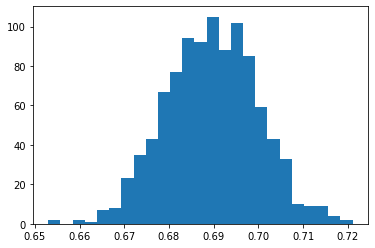

In [101]:
plt.hist(predicciones, bins=25)

In [102]:
np.percentile(predicciones, 2.5), np.percentile(predicciones, 50), np.percentile(predicciones, 97.5)

(0.6698829115236158, 0.6896139350752177, 0.709732606293281)